In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from plotnine import *

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from stargazer import stargazer

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment1/morg-2014-emp.csv')
df.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [3]:
# Filter the data for occ2012 between 7700 and 8965, work week > 0, work minimum 20hrs per week and hourly wage >= 1
comp_sample = df[(df['occ2012'] >= 1005)
                & (df['occ2012'] <= 1107)
                & (df['uhours'] >= 20) 
                & (df['earnwke'] > 0)
                & (df['earnwke']/df['uhours'] >= 1)].iloc[:, 1:]

#drop the raw df
del df

In [4]:
# Add a column 'hourly_wage' to the DataFrame
comp_sample['hourly_wage'] = (comp_sample['earnwke'] / comp_sample['uhours']).round(decimals=2)
# add column female to have boolean for male or female
comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
# create dummy variables for Bachelor degree holders and Post Graduate degree holders
comp_sample['ed_BA'] = (comp_sample["grade92"] == 43).astype(int)
comp_sample['ed_PostGrad'] = (comp_sample["grade92"] >= 44).astype(int)
# add column for age squared
comp_sample['agesq'] = np.power(comp_sample['age'], 2)
# add column for citizen to have boolean value if worker has US citizenship
comp_sample['citizen'] = comp_sample['prcitshp'].apply(lambda x: 0 if 'Not' in x else 1)
# round to 2 decimal places
comp_sample = comp_sample.round(decimals=2)

In [5]:
# check the comp_sample data
comp_sample.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,...,class,unionmme,unioncov,lfsr94,hourly_wage,female,ed_BA,ed_PostGrad,agesq,citizen
16,731019430119001,January,AL,2992.10,1538.46,40,43,2,NaN,53,...,"Private, For Profit",No,No,Employed-At Work,38.46,1,1,0,2809,1
155,673032906039520,January,AK,411.56,1346.15,40,39,3,NaN,47,...,Government - Local,No,No,Employed-At Work,33.65,1,0,0,2209,1
293,207004430306994,January,AZ,3410.89,2500.00,40,44,4,NaN,51,...,"Private, For Profit",No,No,Employed-At Work,62.50,0,0,1,2601,1
296,236096309400800,January,AZ,3916.33,2500.00,40,43,4,NaN,47,...,"Private, For Profit",No,No,Employed-At Work,62.50,0,1,0,2209,1
324,914299270769003,January,AZ,5115.47,1250.00,45,43,1,NaN,37,...,"Private, For Profit",No,No,Employed-At Work,27.78,0,1,0,1369,1


In [6]:
# get the comp_sample summary statistics
comp_stats = comp_sample[['earnwke', 'uhours', 'hourly_wage']].describe().T
comp_stats['mode'] = comp_sample[['earnwke', 'uhours', 'hourly_wage']].mode().squeeze()
comp_stats.T

,earnwke,uhours,hourly_wage
count,4326.000000,4326.000000,4326.000000
mean,1433.989760,41.486362,34.507612
std,668.489938,5.659811,15.660631
min,92.300000,20.000000,2.310000
25%,920.000000,40.000000,22.235000
50%,1346.150000,40.000000,32.200000
75%,1923.000000,40.000000,45.000000
max,2884.610000,80.000000,120.190000
mode,2884.610000,40.000000,48.080000


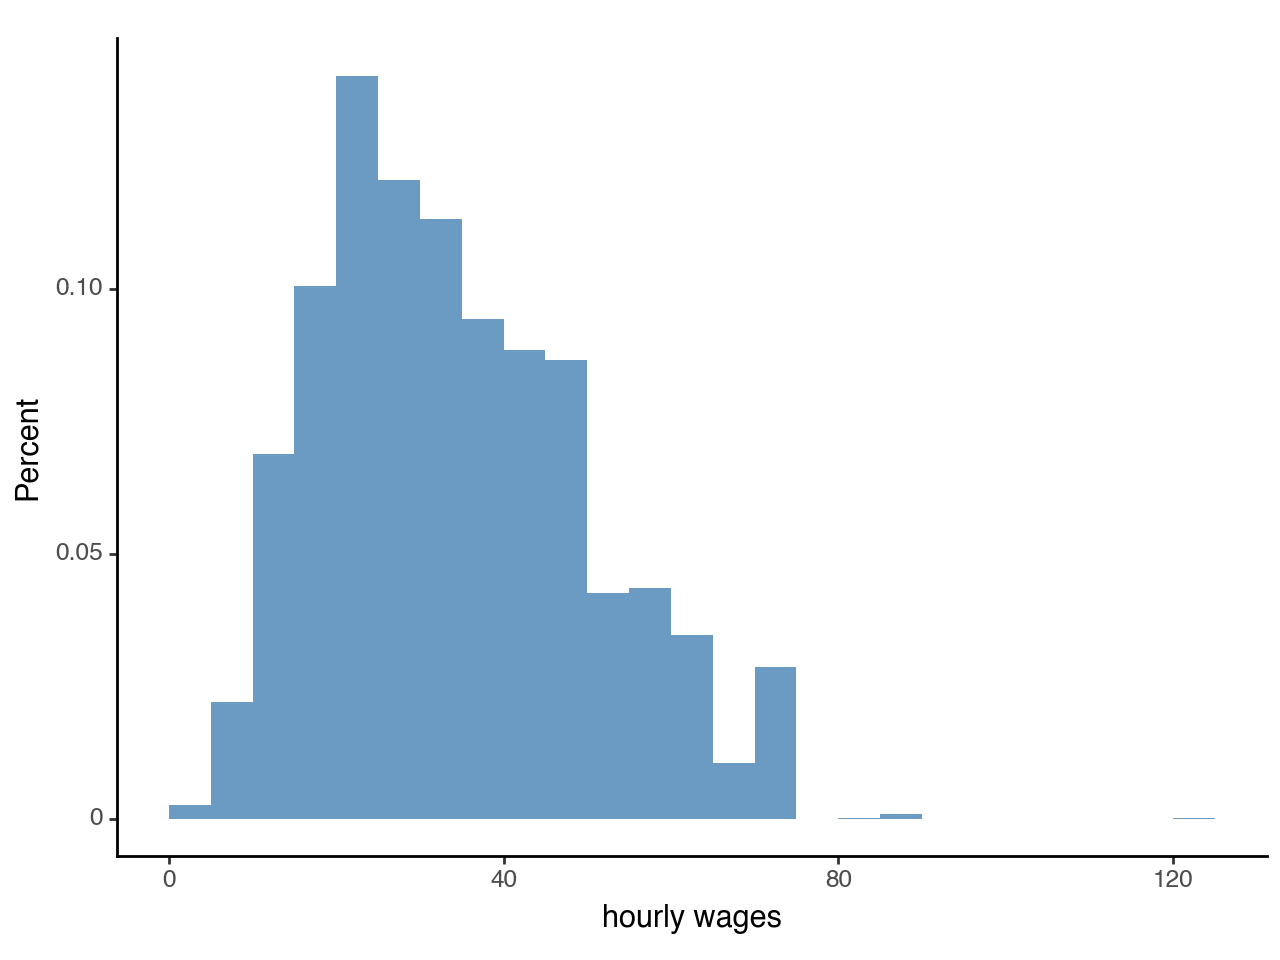

<Figure Size: (640 x 480)>

In [7]:
# hourly_wage distribution
(
    ggplot(comp_sample, aes(x="hourly_wage", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=5,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
        fill='steelblue'
    )
    + labs(x="hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + theme_classic()
)

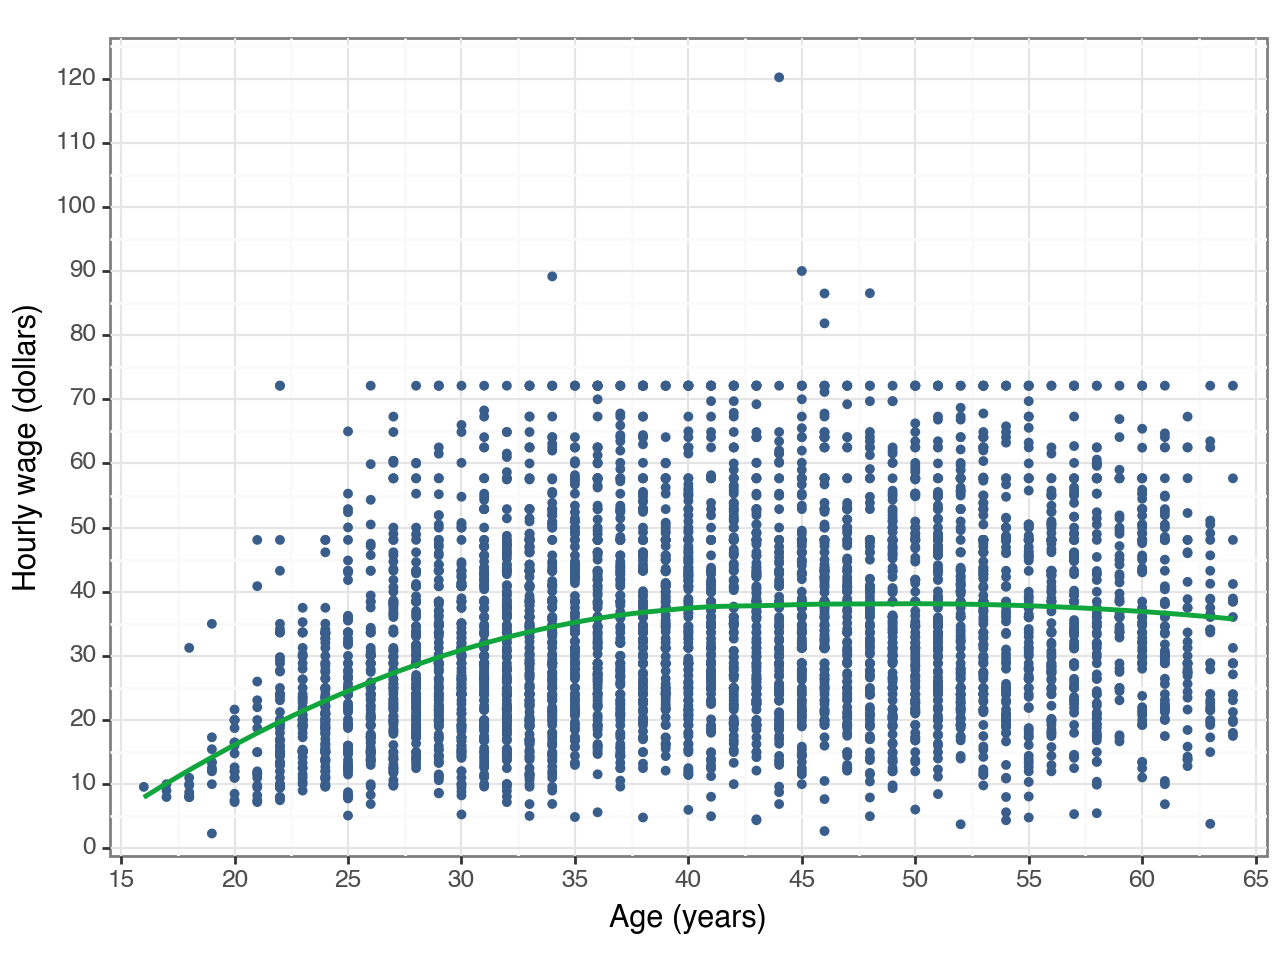

<Figure Size: (640 x 480)>

In [8]:
# lowess
(ggplot(comp_sample, aes(x="age", y="hourly_wage")) 
 + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True) 
 + geom_smooth(method="loess", se=False, colour=color[1], size=1, span=0.9) 
 + labs(
    x="Age (years)", y="Hourly wage (dollars)") 
 + theme_bw() 
 + expand_limits(x=0.01, y=0.01)
 + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 125), breaks=seq(0, 125, 10))
 + scale_x_continuous(expand=(0.01, 0.01), limits=(15, 65), breaks=seq(0, 65, 5))
 )

In [9]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in kfold.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [10]:
comp_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4326 entries, 16 to 149221
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hhid         4326 non-null   int64  
 1   intmonth     4326 non-null   object 
 2   stfips       4326 non-null   object 
 3   weight       4326 non-null   float64
 4   earnwke      4326 non-null   float64
 5   uhours       4326 non-null   int64  
 6   grade92      4326 non-null   int64  
 7   race         4326 non-null   int64  
 8   ethnic       222 non-null    float64
 9   age          4326 non-null   int64  
 10  sex          4326 non-null   int64  
 11  marital      4326 non-null   int64  
 12  ownchild     4326 non-null   int64  
 13  chldpres     4326 non-null   int64  
 14  prcitshp     4326 non-null   object 
 15  state        4326 non-null   object 
 16  ind02        4326 non-null   object 
 17  occ2012      4326 non-null   int64  
 18  class        4326 non-null   object 
 19  unionmme

In [11]:
# regression formulas
reg_formulas = ["hourly_wage~age+agesq",
                "hourly_wage~age+agesq+citizen",
                "hourly_wage~age+agesq+citizen+female+ownchild",
                "hourly_wage~age+agesq+citizen+female+ownchild+ed_BA+ed_PostGrad"]

In [15]:
k = KFold(n_splits=5, shuffle=False, random_state=None)

# create 4 cross validations
cv1 = cv_reg(reg_formulas[0], comp_sample, k, "HC1")
cv2 = cv_reg(reg_formulas[1], comp_sample, k, "HC1")
cv3 = cv_reg(reg_formulas[2], comp_sample, k, "HC1")
cv4 = cv_reg(reg_formulas[3], comp_sample, k, "HC1")

cv_list = [cv1, cv2, cv3, cv4]

cv_summary = summarize_cv(cv_list).round(decimals=3)
cv_summary

,Model1,Model2,Model3,Model4
Fold1,14.887,14.799,14.600,13.978
Fold2,14.965,14.836,14.635,13.876
Fold3,14.900,14.803,14.586,13.958
Fold4,14.738,14.615,14.444,13.774
Fold5,14.770,14.674,14.436,13.822
Average,14.852,14.745,14.540,13.882


In [17]:
# create the regression models
reg1 = smf.ols(formula=reg_formulas[0], data=comp_sample).fit(cov_type="HC1")
reg2 = smf.ols(formula=reg_formulas[1], data=comp_sample).fit(cov_type="HC1")
reg3 = smf.ols(formula=reg_formulas[2], data=comp_sample).fit(cov_type="HC1")
reg4 = smf.ols(formula=reg_formulas[3], data=comp_sample).fit(cov_type="HC1")

reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
rmse_all = [round(rmse(comp_sample[reg_formulas[x].split("~")[0]], reg_list[x].predict()), 3) for x in range(len(reg_list))]
rmse_kfold = (cv_summary.loc['Average']).tolist()
sg = stargazer.Stargazer(reg_list)
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('RMSE', rmse_all, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('CV RMSE', rmse_kfold, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg